# About

This notebook contains code for fine-tuning Llama-3.2-1B model for text classification to sections.

The texts are classified to the top 10 most frequent sections and the rest are classified as "Other"

Fine-tuning is done using QLORA.

The resulting model is integrated into Question Answering pipeline using Haystack.

Code is intended to run on a cuda architecture

All code was compiled using A100 GPU on google colab

Loading up and training the model takes < 20 GB of GPU RAM (so L4 GPU could be used as well, but the training will be slower)

In [ ]:
%autosave 60

Autosaving every 60 seconds


Log in to Hugging Face

Needed for loading models and dataset

In [ ]:
hf_token = "<hf_token>"

from huggingface_hub import login
login(token=hf_token)

Mount Google Drive

Used for saving and loading trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install haystack-ai datasets transformers
!pip install -U bitsandbytes
!pip install evaluate

!pip install haystack-ai
!pip install chroma-haystack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.7/624.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 89.7 MB/s eta

In [ ]:
import numpy as np
import torch

from collections import Counter

from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, Trainer, TrainingArguments, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftConfig, PeftModel

import torch.nn.functional as F
import evaluate

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from haystack import Document
from haystack import Pipeline
from haystack import component
from haystack.components.builders import ChatPromptBuilder
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator
from haystack.components.writers import DocumentWriter
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack.utils.hf import HFGenerationAPIType
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

In [ ]:
loaded_dataset = load_dataset("Justelioo/text-section-classification")
print(loaded_dataset)

README.md:   0%|          | 0.00/355 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2101279 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'section', 'text'],
        num_rows: 2101279
    })
})


Calculate top sections

In [ ]:
sections_counts = Counter()

for sample in loaded_dataset:
  sections_counts[sample["section"]] += 1

top_section_counts = dict(sections_counts.most_common(10))
section_list = list(top_section_counts.keys())
top_sections = set(section_list)
section_list.append("Other")

In [ ]:
section_to_index = {section: idx for idx, section in enumerate(section_list)}
index_to_section = {idx: section for idx, section in enumerate(section_list)}
print(section_to_index)
print(index_to_section)

{'History': 0, 'Applications': 1, 'Examples': 2, 'Types': 3, 'Overview': 4, 'Function': 5, 'Structure': 6, 'Description': 7, 'Definition': 8, 'Diagnosis': 9, 'Other': 10}
{0: 'History', 1: 'Applications', 2: 'Examples', 3: 'Types', 4: 'Overview', 5: 'Function', 6: 'Structure', 7: 'Description', 8: 'Definition', 9: 'Diagnosis', 10: 'Other'}


Inspect values

In [ ]:
loaded_dataset.filter(lambda example: example["section"] == "Types", num_proc=16)[45:55]

{'title': ['Concrete plant',
  'Artificial neural network',
  'Artificial neural network',
  'Drawing room play',
  'Meteorological instrumentation',
  'Meteorological instrumentation',
  'Meteorological instrumentation',
  'Electromagnetic pulse',
  'Electromagnetic pulse',
  'Electromagnetic pulse'],
 'section': ['Types',
  'Types',
  'Types',
  'Types',
  'Types',
  'Types',
  'Types',
  'Types',
  'Types',
  'Types'],
 'text': ['Stationary concrete plant The stationary concrete plant is designed to produce high-quality concrete. It has the advantages of large output, high efficiency, high stability and high specification. Stationary concrete batching plants are reliable and flexible, easy to maintain and have a low failure rate. They are widely used in various projects such as roads and bridges, ports, tunnels, dams and buildings.',
  'ANNs have evolved into a broad family of techniques that have advanced the state of the art across multiple domains. The simplest types have one or 

In [ ]:
def load_data(other_data_count, seed=7):

  other_data = loaded_dataset.filter(lambda example: example["section"] not in top_sections, num_proc=16)
  top_section_data = loaded_dataset.filter(lambda example: example["section"] in top_sections, num_proc=16)

  selected_other_data = other_data.select(range(other_data_count))

  dataset = concatenate_datasets([top_section_data, selected_other_data])
  dataset = dataset.shuffle(seed=seed)

  dataset = dataset.train_test_split(train_size=0.8, seed=seed)

  test_dataset = dataset.pop("test")

  test_validation_dataset = test_dataset.train_test_split(train_size=0.5, seed=seed)

  dataset["validation"] = test_validation_dataset["train"]
  dataset["test"] = test_validation_dataset["test"]

  return dataset

In [ ]:
def prepare_tokenizer(checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  tokenizer.pad_token_id = tokenizer.eos_token_id
  tokenizer.pad_token = tokenizer.eos_token

  return tokenizer

In [ ]:
def process_data(dataset, tokenizer, truncation=True, max_length=512):
  def tokenize(example):
    tokenized = tokenizer(example['text'], truncation=truncation, max_length=max_length)
    tokenized['label'] = [section_to_index.get(section, 10) for section in example['section']]
    return tokenized

  tokenized = dataset.map(tokenize, batched=True, num_proc=16, remove_columns=['title', 'section', 'text'])
  return tokenized

Define QLora configs

In [ ]:
quantization_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type='nf4',
      bnb_4bit_use_double_quant=True,
      bnb_4bit_compute_dtype=torch.bfloat16
  )

num_labels = 11

def prepare_model(checkpoint, tokenizer):
  model = AutoModelForSequenceClassification.from_pretrained(
      checkpoint,
      quantization_config=quantization_config,
      num_labels = num_labels,
      device_map="auto",
      )

  lora_config = LoraConfig(
      r = 32,
      lora_alpha = 32,
      target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
      lora_dropout = 0.05,
      bias = 'none',
      task_type='SEQ_CLS',
  )

  prepared_model = prepare_model_for_kbit_training(model)

  peft_model = get_peft_model(prepared_model, lora_config)

  peft_model.config.pad_token_id = tokenizer.pad_token_id
  peft_model.config.use_cache = False
  peft_model.config.pretraining_tp = 1

  return peft_model

Define metrics

In [ ]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def calculate_metrics(predictions, labels):
  accuracy_metric = accuracy.compute(predictions = predictions, references=labels)
  precision_metric = precision.compute(predictions = predictions, references=labels, average="macro")
  recall_metric = recall.compute(predictions = predictions, references=labels, average="macro")
  f1_metric = f1.compute(predictions = predictions, references=labels, average="macro")
  cm = confusion_matrix(labels, predictions)

  return {
      "accuracy": accuracy_metric["accuracy"],
      "precision": precision_metric["precision"],
      "recall": recall_metric["recall"],
      "f1": f1_metric["f1"],
  }

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return calculate_metrics(predictions, labels)

def evaluate_model(trainer, dataset, class_names):
  preds = trainer.predict(dataset)
  labels = preds.label_ids
  predictions = np.argmax(preds.predictions, axis=1)

  cm = confusion_matrix(labels, predictions, normalize='true')

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  return calculate_metrics(predictions, labels)

Define custom Trainer class to support loss with class weights

Intended to counteract inbalanced dataset sections

Ablations suggest class weights impact performance negatively

In [ ]:
class TrainerWithClassWeights(Trainer):
  def __init__(self, *args, class_weights, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_weights = class_weights.to("cuda")

  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    outputs = model(**inputs)
    logits = outputs['logits']
    labels = inputs['labels']

    loss = F.cross_entropy(logits, labels, weight=self.class_weights)

    return (loss, outputs) if return_outputs else loss

def prepare_trainer(model, tokenizer, dataset, output_dir="trained_model", class_weights=None):
  training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = 1e-4,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = 5,
    weight_decay = 0.01,
    eval_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="epoch",
    load_best_model_at_end = True,
    metric_for_best_model="f1",
    bf16=True,
    group_by_length=True,
    lr_scheduler_type="cosine",
  )

  collator = DataCollatorWithPadding(tokenizer = tokenizer)

  if class_weights is not None:
    return TrainerWithClassWeights(
      model = model,
      args = training_args,
      train_dataset = dataset['train'],
      eval_dataset = dataset['validation'],
      processing_class=tokenizer,
      data_collator=collator,
      compute_metrics=compute_metrics,
      class_weights=class_weights,
    )
  else:
    return Trainer(
      model = model,
      args = training_args,
      train_dataset = dataset['train'],
      eval_dataset = dataset['validation'],
      processing_class=tokenizer,
      data_collator=collator,
      compute_metrics=compute_metrics,
    )

In [ ]:
def calculate_class_weights(other_data_count):

  top_section_counts['Other'] = other_data_count

  counts = torch.tensor(list(top_section_counts.values()))

  total_count = counts.sum()
  frequencies = counts / total_count

  class_weights = 1 / frequencies
  class_weights_sum = class_weights.sum()
  class_weights = class_weights / class_weights_sum
  return class_weights

In [ ]:
checkpoint = "meta-llama/Llama-3.2-1B"
model_save_dir = "drive/MyDrive/final/1b-512cl-nocw-other50k"
other_data_count = 50000

In [ ]:
dataset = load_data(other_data_count=other_data_count)
tokenizer = prepare_tokenizer(checkpoint)
tokenized = process_data(dataset, tokenizer)
model = prepare_model(checkpoint, tokenizer)
# class_weights = calculate_class_weights(other_data_count)
trainer = prepare_trainer(model, tokenizer, tokenized, model_save_dir, class_weights=None)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculate data token count quantiles to choose suitable truncation length

In [ ]:
untruncated_data = process_data(dataset, tokenizer, truncation=False)
lengths = untruncated_data.map(lambda example: {"token_length": [len(ids) for ids in example['input_ids']]}, batched=True, num_proc=16)

quantiles = np.quantile(lengths["test"]['token_length'], [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
quantiles

array([   9.,   19.,   51.,   84.,  124.,  193.,  303.,  398.,  664.,
       2442.])

Evaluate model before training

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: justasmileika (justasmileika-freelancer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


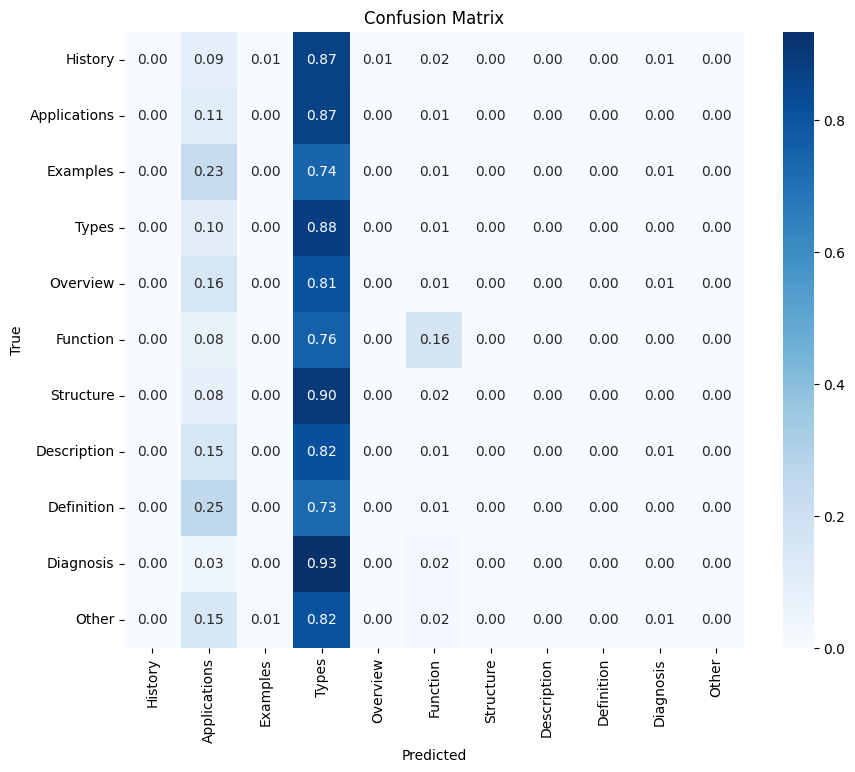

{'accuracy': 0.07603002502085071,
 'precision': 0.10384537751013573,
 'recall': 0.10573148594342169,
 'f1': 0.04160723483641549}

In [ ]:
evaluate_model(trainer, tokenized["test"], section_list)

In [ ]:
trained = trainer.train()
trained

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.940300,0.859643,0.002800,0.716797,0.685876,0.622674,0.629767
2,0.773500,0.794043,0.002800,0.736614,0.690714,0.658793,0.666127
3,0.613500,0.802402,0.002800,0.742452,0.694291,0.664769,0.675475
4,0.438200,0.881581,0.002800,0.742052,0.683814,0.674504,0.677273


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.940300,0.859643,0.002800,0.716797,0.685876,0.622674,0.629767
2,0.773500,0.794043,0.002800,0.736614,0.690714,0.658793,0.666127
3,0.613500,0.802402,0.002800,0.742452,0.694291,0.664769,0.675475
4,0.438200,0.881581,0.002800,0.742052,0.683814,0.674504,0.677273
5,0.324600,0.981412,0.002800,0.736013,0.682972,0.667660,0.674722


TrainOutput(global_step=18735, training_loss=0.618030036007973, metrics={'train_runtime': 15465.0138, 'train_samples_per_second': 77.529, 'train_steps_per_second': 1.211, 'total_flos': 1.125956223022166e+18, 'train_loss': 0.618030036007973, 'epoch': 5.0})

Evaluate on test set after training

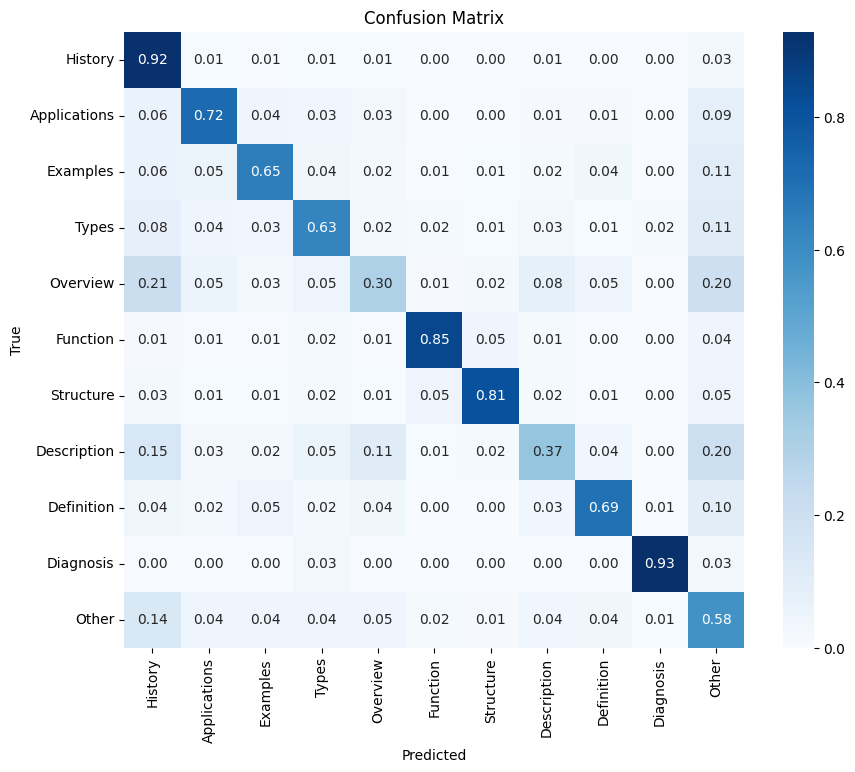

{'accuracy': 0.7394495412844037,
 'precision': 0.6834739870133604,
 'recall': 0.6770694742640516,
 'f1': 0.6786656853093928}

In [ ]:
evaluate_model(trainer, tokenized["test"], section_list)

Evaluating on bigger dataset (with more 'Other' section data)

Used for evaluating the hyperparameter `other_data_count`, since choosing different values yields different `test` dataset size

Map (num_proc=16):   0%|          | 0/359797 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/44975 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/44975 [00:00<?, ? examples/s]

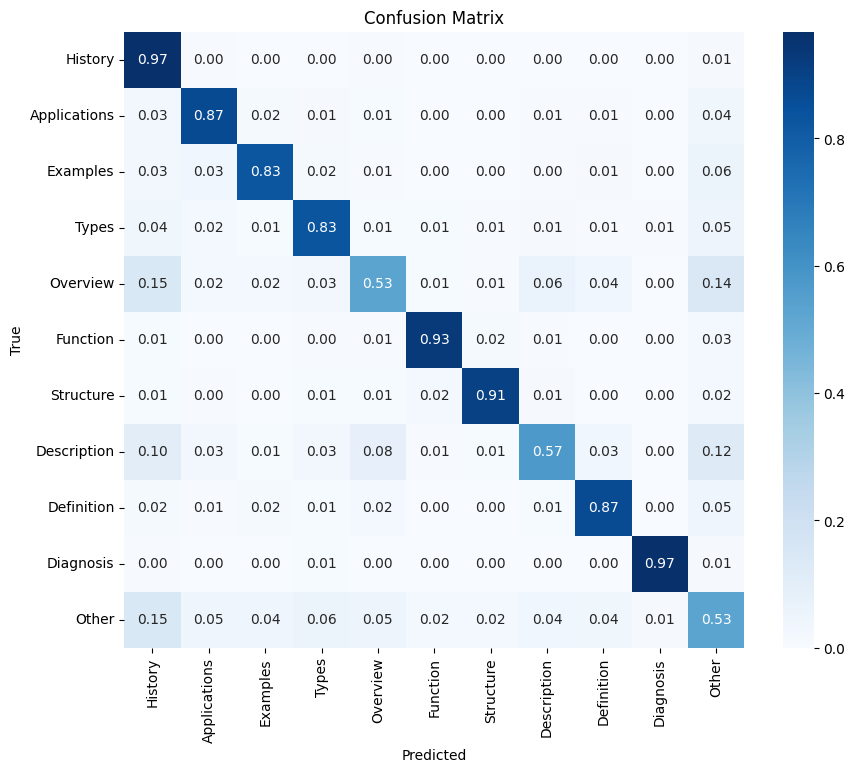

{'accuracy': 0.722290161200667,
 'precision': 0.6374099490270742,
 'recall': 0.7987926634120374,
 'f1': 0.6971668329279993}

In [ ]:
bigger_dataset = load_data(other_data_count=200000)
bigger_tokenized = process_data(bigger_dataset, tokenizer)
evaluate_model(trainer, bigger_tokenized["test"], section_list)

In [ ]:
def save_trained(save_directory, trainer, tokenizer):
  trainer.save_model(save_directory)
  model.config.save_pretrained(save_directory)
  tokenizer.save_pretrained(save_directory)

Save best loaded model after training to a different folder

In [ ]:
save_directory = f"{model_save_dir}-final"

In [ ]:
save_trained(save_directory, trainer, tokenizer)

In [ ]:
def load_saved_model(save_directory, tokenizer):
  peft_config = PeftConfig.from_pretrained(save_directory)

  base_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    quantization_config=quantization_config,
    num_labels=num_labels,
    device_map="auto",
  )

  peft_model = PeftModel.from_pretrained(base_model, save_directory)

  peft_model.config.pad_token_id = tokenizer.pad_token_id

  return peft_model


def load_saved_tokenizer(save_directory):
  return AutoTokenizer.from_pretrained(save_directory)

Loading and evaluating saved model

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=16):   0%|          | 0/359797 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/44975 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/44975 [00:00<?, ? examples/s]

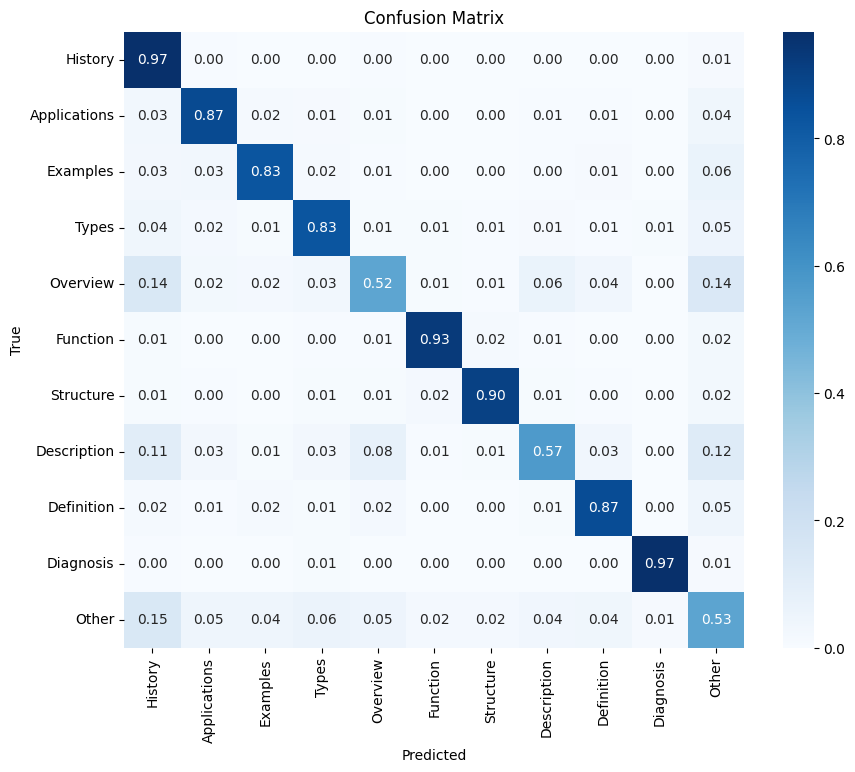

{'accuracy': 0.7218677042801557,
 'precision': 0.6367003229430316,
 'recall': 0.7983467965870754,
 'f1': 0.6965679051396078}

In [ ]:
dataset = load_data(other_data_count=200000)
loaded_tokenizer = load_saved_tokenizer(save_directory)
loaded_model = load_saved_model(save_directory, loaded_tokenizer)
tokenized = process_data(dataset, loaded_tokenizer)
loaded_trainer = prepare_trainer(loaded_model, loaded_tokenizer, tokenized)
evaluate_model(loaded_trainer, tokenized["test"], section_list)

Defining custom haystack components

In [ ]:
@component
class DocumentClassification:

  def __init__(self, model_dir):
    self.model_dir = model_dir

  def _load_model(self, directory, tokenizer):
    peft_config = PeftConfig.from_pretrained(directory)

    base_model = AutoModelForSequenceClassification.from_pretrained(
      peft_config.base_model_name_or_path,
      quantization_config=quantization_config,
      num_labels=num_labels,
      device_map="auto",
    )

    peft_model = PeftModel.from_pretrained(base_model, directory)

    peft_model.config.pad_token_id = tokenizer.pad_token_id

    return peft_model


  def _load_tokenizer(self, directory):
    return AutoTokenizer.from_pretrained(directory)

  def warm_up(self):
    self.tokenizer = self._load_tokenizer(self.model_dir)
    self.model = self._load_model(self.model_dir, self.tokenizer)


  @component.output_types(documents=List[Document])
  def run(self, documents: List[Document]):

    contents = [document.content for document in documents]

    tokenized = self.tokenizer(contents, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")

    with torch.no_grad():
      outputs = self.model(**tokenized)
      logits = outputs.logits
      labels = torch.argmax(logits, dim=1)

    for idx, label in enumerate(labels):
      documents[idx].meta["classification"] = label.item()

    return {"documents": documents}

@component
class TextToDocumentConverter:

    @component.output_types(document=Document)
    def run(self, text: str):
        return {"document": Document(content=text)}

@component
class DocumentToDocumentListConverter:

    @component.output_types(documents=List[Document])
    def run(self, document: Document):
        return {"documents": [document]}

@component
class DocumentListToDocumentConverter:

    @component.output_types(document=Document)
    def run(self, documents: List[Document]):
        return {"document": documents[0]}

@component
class DocumentSectionRouter:

    def __init__(self, sections: List[int]):
        self.sections = sections

    @component.output_types(rag_route=str, log_question_route=Document)
    def run(self, document: Document):
        if document.meta["classification"] in self.sections:
            return {"rag_route": document.content}
        else:
            return {"log_question_route": document}

In [ ]:
db_persist_path = "documents-storage"

embedding_model = "sentence-transformers/all-MiniLM-L6-v2"

chat_model = "meta-llama/Meta-Llama-3-8B-Instruct"

documents = [
    Document(content="Sir Winston Leonard Spencer Churchill[a] (30 November 1874 – 24 January 1965) was a British statesman, military officer, and writer who was Prime Minister of the United Kingdom from 1940 to 1945 (during the Second World War) and again from 1951 to 1955. For some 62 of the years between 1900 and 1964, he was a member of parliament (MP) and represented a total of five constituencies over that time. Ideologically an adherent to economic liberalism and imperialism, he was for most of his career a member of the Conservative Party, which he led from 1940 to 1955. He was a member of the Liberal Party from 1904 to 1924."),
    Document(content="Michael Jeffrey Jordan (born February 17, 1963), also known by his initials MJ,[8] is an American businessman, former professional basketball player and former professional baseball player, who is currently a minority owner of the Charlotte Hornets of the National Basketball Association (NBA). He played 15 seasons in the NBA between 1984 and 2003, winning six NBA championships with the Chicago Bulls. Widely considered to be one of the greatest players of all time,[9][10][11] he was integral in popularizing basketball and the NBA around the world in the 1980s and 1990s,[12] becoming a global cultural icon.[13]"),
    Document(content="In deep learning, transformer is an architecture based on the multi-head attention mechanism, in which text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table.[1] At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism, allowing the signal for key tokens to be amplified and less important tokens to be diminished.Transformers have the advantage of having no recurrent units, therefore requiring less training time than earlier recurrent neural architectures (RNNs) such as long short-term memory (LSTM).[2] Later variations have been widely adopted for training large language models (LLMs) on large (language) datasets.[3] The modern version of the transformer was proposed in the 2017 paper 'Attention Is All You Need' by researchers at Google.[1] Transformers were first developed as an improvement over previous architectures for machine translation,[4][5] but have found many applications since. They are used in large-scale natural language processing, computer vision (vision transformers), reinforcement learning,[6][7] audio,[8] multimodal learning, robotics,[9] and even playing chess.[10] It has also led to the development of pre-trained systems, such as generative pre-trained transformers (GPTs)[11] and BERT[12] (bidirectional encoder representations from transformers)."),
    Document(content="Runner's knee, also known as patellofemoral pain syndrome (PFPS), is diagnosed through a combination of physical examination, symptom assessment, and sometimes imaging tests. A doctor will evaluate your medical history, physical activity, and symptoms to determine if it's PFPS. "),
    Document(content="The Roman Empire ruled the Mediterranean and much of Europe, Western Asia and North Africa. The Romans conquered most of this during the Republic, and it was ruled by emperors following Octavian's assumption of effective sole rule in 27 BC. The western empire collapsed in 476 AD, but the eastern empire lasted until the fall of Constantinople in 1453. By 100 BC, the city of Rome had expanded its rule from the Italian peninsula to most of the Mediterranean and beyond. However, it was severely destabilised by civil wars and political conflicts, which culminated in the victory of Octavian over Mark Antony and Cleopatra at the Battle of Actium in 31 BC, and the subsequent conquest of the Ptolemaic Kingdom in Egypt. In 27 BC, the Roman Senate granted Octavian overarching military power (imperium) and the new title of Augustus, marking his accession as the first Roman emperor. The vast Roman territories were organized into senatorial provinces, governed by proconsuls who were appointed by lot annually, and imperial provinces, which belonged to the emperor but were governed by legates."),
    Document(content="In Predynastic and Early Dynastic times, the Egyptian climate was much less arid than it is today. Large regions of Egypt were savanna and traversed by herds of grazing ungulates. Foliage and fauna were far more prolific in all environs, and the Nile region supported large populations of waterfowl. Hunting would have been common for Egyptians, and this is also the period when many animals were first domesticated.[9] By about 5500 BC, small tribes living in the Nile valley had developed into a series of cultures demonstrating firm control of agriculture and animal husbandry, and identifiable by their pottery and personal items, such as combs, bracelets, and beads. The largest of these early cultures in upper (Southern) Egypt was the Badarian culture, which probably originated in the Western Desert; it was known for its high-quality ceramics, stone tools, and its use of copper.[10]"),
    Document(content="Tertiary structure refers to the three-dimensional structure created by a single protein molecule (a single polypeptide chain). It may include one or several domains. The α-helices and β-pleated-sheets are folded into a compact globular structure. The folding is driven by the non-specific hydrophobic interactions, the burial of hydrophobic residues from water, but the structure is stable only when the parts of a protein domain are locked into place by specific tertiary interactions, such as salt bridges, hydrogen bonds, and the tight packing of side chains and disulfide bonds. The disulfide bonds are extremely rare in cytosolic proteins, since the cytosol (intracellular fluid) is generally a reducing environment."),
    Document(content="COVID-19 can be diagnosed through tests that detect either current or past infection. Tests for current infection, also known as viral tests, look for the presence of the virus itself, while tests for past infection, or antibody tests, detect antibodies produced in response to the virus. Common viral tests include molecular tests, such as PCR tests, which identify the virus's genetic material. "),
    Document(content="Universities can be broadly categorized into public, private, and for-profit institutions. Further classifications include liberal arts colleges, community colleges, research universities, and specialized institutions like technical schools or art colleges. Each type offers distinct educational approaches and focuses"),
    Document(content="Neural networks are broadly categorized into several types based on their architecture and function. Key types include Feedforward Neural Networks (FNNs), Recurrent Neural Networks (RNNs), and Convolutional Neural Networks (CNNs). Each type is designed for specific tasks and data types"),
]

Indexing documents pipeline

In [ ]:
document_store = ChromaDocumentStore(persist_path=db_persist_path, collection_name="documents")
document_writer = DocumentWriter(document_store=document_store)

document_embedder = SentenceTransformersDocumentEmbedder(model=embedding_model)
document_embedder.warm_up()

document_classification_indexing = DocumentClassification(model_dir=save_directory)
document_classification_indexing.warm_up()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
document_indexing = Pipeline()

document_indexing.add_component("document_classification_indexing", document_classification_indexing)
document_indexing.add_component("document_writer", document_writer)

document_indexing.connect("document_classification_indexing", "document_writer")

document_indexing

🚅 Components
  - document_classification_indexing: DocumentClassification
  - document_writer: DocumentWriter
🛤️ Connections
  - document_classification_indexing.documents -> document_writer.documents (List[Document])

In [ ]:
document_indexing.run({"documents": documents})

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'document_writer': {'documents_written': 10}}

In [ ]:
def list_documents():
    stored_docs = document_store.filter_documents()
    return {doc.content[:100]: index_to_section[doc.meta["classification"]] for doc in stored_docs}

list_documents()

{'Sir Winston Leonard Spencer Churchill[a] (30 November 1874 – 24 January 1965) was a British statesma': 'Examples',
 'Michael Jeffrey Jordan (born February 17, 1963), also known by his initials MJ,[8] is an American bu': 'Other',
 'In deep learning, transformer is an architecture based on the multi-head attention mechanism, in whi': 'Other',
 "Runner's knee, also known as patellofemoral pain syndrome (PFPS), is diagnosed through a combination": 'Diagnosis',
 'The Roman Empire ruled the Mediterranean and much of Europe, Western Asia and North Africa. The Roma': 'History',
 'In Predynastic and Early Dynastic times, the Egyptian climate was much less arid than it is today. L': 'History',
 'Tertiary structure refers to the three-dimensional structure created by a single protein molecule (a': 'Structure',
 'COVID-19 can be diagnosed through tests that detect either current or past infection. Tests for curr': 'Diagnosis',
 'Universities can be broadly categorized into public, private, and f

Question answering pipeline

In [ ]:
sections = [0]

query_to_document_converter = TextToDocumentConverter()
document_classification_adapter = DocumentToDocumentListConverter()
document_classification = DocumentClassification(model_dir=save_directory)
document_classification.warm_up()
document_classification_post_processor = DocumentListToDocumentConverter()

document_section_router = DocumentSectionRouter(sections=sections)

document_retriever = ChromaQueryTextRetriever(
    document_store=document_store,
    top_k=3,
    filters={"field": "classification", "operator": "in", "value": sections},
)

template = [
    ChatMessage.from_user(
        """
        You are a question answering agent. Given the following context, answer the user's question.

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{ query }}
        Answer:
        """
    )
]

prompt_builder = ChatPromptBuilder(template=template, required_variables=["query", "documents"])

generator = HuggingFaceAPIChatGenerator(api_type=HFGenerationAPIType.SERVERLESS_INFERENCE_API,
                                        api_params={"model": chat_model},
                                        token=Secret.from_token(hf_token))

log_writer_adapter = DocumentToDocumentListConverter()

log_document_store = ChromaDocumentStore(persist_path=db_persist_path, collection_name="logs")
log_writer = DocumentWriter(document_store=log_document_store)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
rag_pipeline = Pipeline()

rag_pipeline.add_component("query_to_document_converter", query_to_document_converter)
rag_pipeline.add_component("document_classification_adapter", document_classification_adapter)
rag_pipeline.add_component("document_classification", document_classification)
rag_pipeline.add_component("document_classification_post_processor", document_classification_post_processor)
rag_pipeline.add_component("document_section_router", document_section_router)

rag_pipeline.add_component("document_retriever", document_retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("generator", generator)

rag_pipeline.add_component("log_writer_adapter", log_writer_adapter)
rag_pipeline.add_component("log_writer", log_writer)

rag_pipeline.connect("query_to_document_converter", "document_classification_adapter")
rag_pipeline.connect("document_classification_adapter", "document_classification")
rag_pipeline.connect("document_classification", "document_classification_post_processor")
rag_pipeline.connect("document_classification_post_processor", "document_section_router")

rag_pipeline.connect("document_section_router.rag_route", "document_retriever.query")
rag_pipeline.connect("document_section_router.rag_route", "prompt_builder.query")
rag_pipeline.connect("document_retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")

rag_pipeline.connect("document_section_router.log_question_route", "log_writer_adapter")
rag_pipeline.connect("log_writer_adapter", "log_writer")

rag_pipeline

🚅 Components
  - query_to_document_converter: TextToDocumentConverter
  - document_classification_adapter: DocumentToDocumentListConverter
  - document_classification: DocumentClassification
  - document_classification_post_processor: DocumentListToDocumentConverter
  - document_section_router: DocumentSectionRouter
  - document_retriever: ChromaQueryTextRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: HuggingFaceAPIChatGenerator
  - log_writer_adapter: DocumentToDocumentListConverter
  - log_writer: DocumentWriter
🛤️ Connections
  - query_to_document_converter.document -> document_classification_adapter.document (Document)
  - document_classification_adapter.documents -> document_classification.documents (List[Document])
  - document_classification.documents -> document_classification_post_processor.documents (List[Document])
  - document_classification_post_processor.document -> document_section_router.document (Document)
  - document_section_router.rag_route -> documen

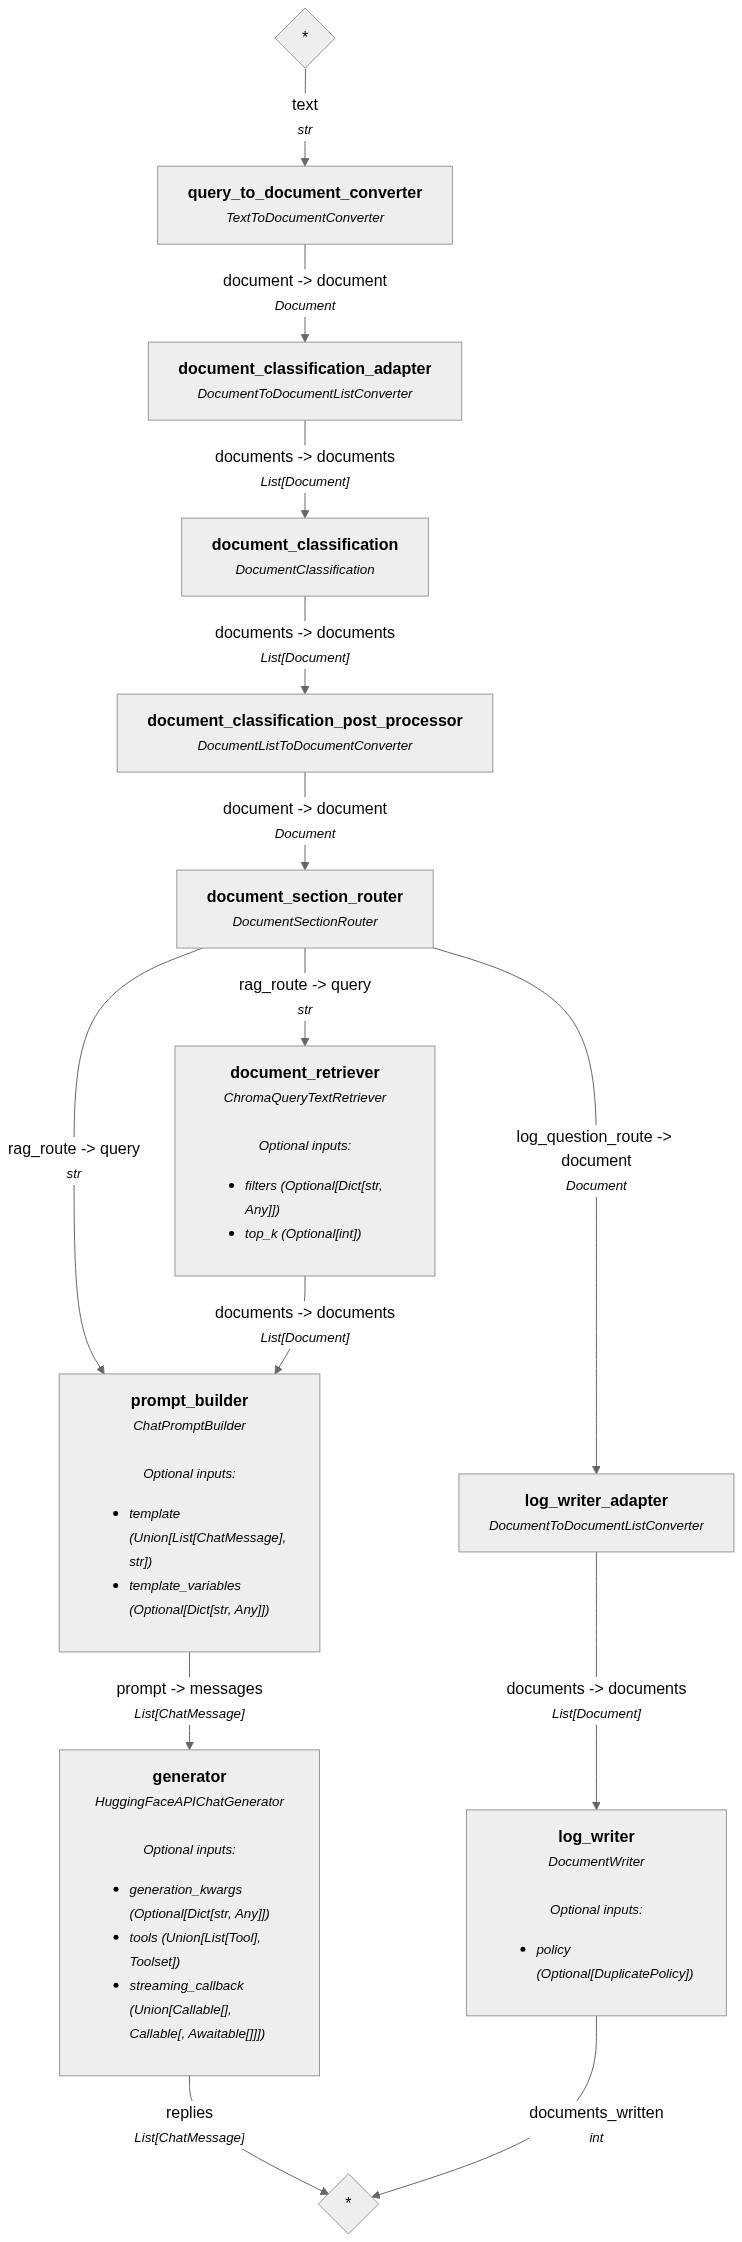

In [ ]:
rag_pipeline.show()

In [ ]:
question = "When did the Roman Empire fall?"

response = rag_pipeline.run(
    {"query_to_document_converter": {"text": question}},
    include_outputs_from=["document_classification"]
    )
response

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'document_classification': {'documents': [Document(id=acc0ceab81c1967846612f285bf7131e7e22f957e488a107c9e35593b3150cc7, content: 'When did the Roman Empire fall?', meta: {'classification': 0})]},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The Roman Empire fell in two stages. The Western Roman Empire collapsed in 476 AD, while the Eastern Roman Empire, also known as the Byzantine Empire, lasted until the fall of Constantinople in 1453 AD.')], _name=None, _meta={'model': 'meta-llama/Meta-Llama-3-8B-Instruct', 'finish_reason': 'stop', 'index': 0, 'usage': {'prompt_tokens': 492, 'completion_tokens': 46}})]}}

In [ ]:
response["generator"]["replies"][0].text

'The Roman Empire fell in two stages. The Western Roman Empire collapsed in 476 AD, while the Eastern Roman Empire, also known as the Byzantine Empire, lasted until the fall of Constantinople in 1453 AD.'

In [ ]:
question = "How do i know if I have runner's knee?"

response = rag_pipeline.run(
    {"query_to_document_converter": {"text": question}},
    include_outputs_from=["document_classification"]
    )
response

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'document_classification': {'documents': [Document(id=cd2f4d33689828618b9ec7d13bd9a76721da03ed4e9c537d56bd0d0498ec05d0, content: 'How do i know if I have runner's knee?', meta: {'classification': 9})]},
 'log_writer': {'documents_written': 1}}

In [ ]:
def get_unanswered_questions():
    documents = log_document_store.filter_documents()
    return [document.content for document in documents]

In [ ]:
get_unanswered_questions()

["How do i know if I have runner's knee?"]